In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.decomposition import PCA

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
DATA_PATH = "iris.csv"         
TARGET_COL = "species"          
RANDOM_STATE = 42
OUTPUT_DIR = "task6_outputs"

In [5]:
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [6]:
# ----------------------------
# Load data
# ----------------------------
if not os.path.exists(DATA_PATH):
    # If iris.csv not present, load from sklearn
    from sklearn.datasets import load_iris
    iris = load_iris(as_frame=True)
    df = iris.frame.rename(columns={"target": "species"})  # sklearn has numeric target; we convert below
    # Convert numeric target to names
    df['species'] = iris.target_names[iris.target]
    print("Using built-in Iris dataset (saved as iris.csv).")
    df.to_csv("iris.csv", index=False)
else:
    df = pd.read_csv(DATA_PATH)


In [7]:
print("\nDataset preview:")
print(df.head())
print("\nDataset shape:", df.shape)


Dataset preview:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

  species  
0  setosa  
1  setosa  
2  setosa  
3  setosa  
4  setosa  

Dataset shape: (150, 5)


In [8]:
# If target is numeric and named 'target' or last column, adjust automatically
if TARGET_COL not in df.columns:
    # fallback: assume last column is target
    TARGET_COL = df.columns[-1]
    print(f"TARGET_COL not found. Using last column as target: '{TARGET_COL}'")



--- Value counts for target ---
species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64


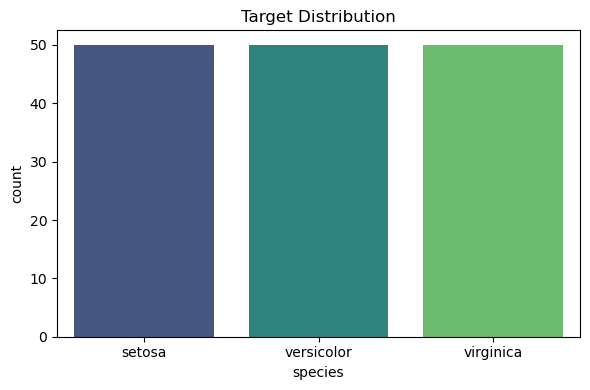

In [9]:
# ----------------------------
# Basic EDA
# ----------------------------
print("\n--- Value counts for target ---")
print(df[TARGET_COL].value_counts())
plt.figure(figsize=(6,4))
sns.countplot(x=TARGET_COL, data=df, palette="viridis")
plt.title("Target Distribution")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "target_distribution.png"))
plt.show()

In [10]:
# numeric columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols) == 0:
    # if numeric columns absent (Iris has numeric), try to coerce features
    # assume all non-target are features
    feature_cols = [c for c in df.columns if c != TARGET_COL]
    # try convert to numeric where possible
    df[feature_cols] = df[feature_cols].apply(pd.to_numeric, errors='coerce')
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()


In [11]:
print("\nNumeric columns used as features:", num_cols)


Numeric columns used as features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [12]:
df["species"]= df["species"].replace({"setosa":0,"versicolor":1,"virginica":2})

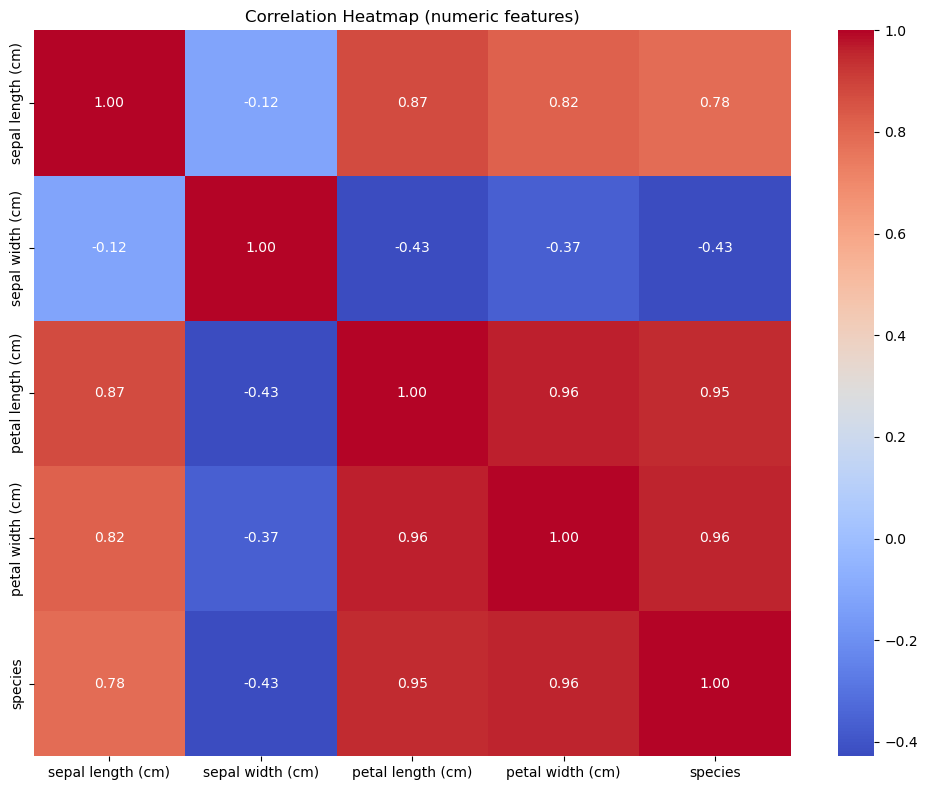

In [13]:
# correlation heatmap (only numeric)
if len(num_cols) >= 2:
    plt.figure(figsize=(10,8))
    sns.heatmap(df[num_cols + [TARGET_COL]].corr(), annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Correlation Heatmap (numeric features)")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "correlation_heatmap.png"))
    plt.show()


<Figure size 1200x600 with 0 Axes>

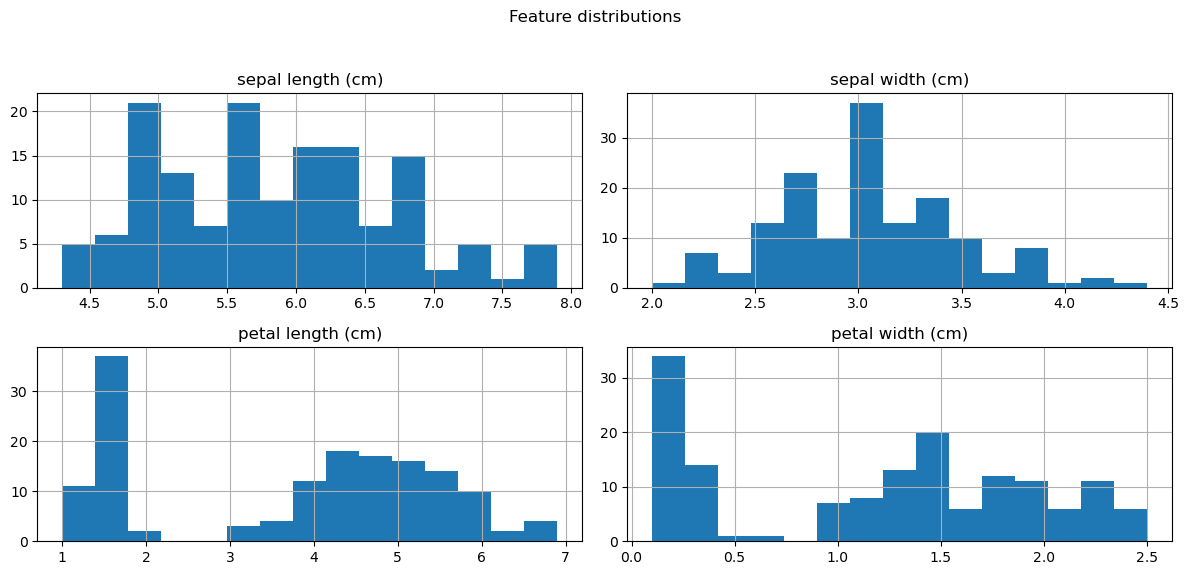

In [14]:
# distributions
plt.figure(figsize=(12,6))
df[num_cols].hist(figsize=(12,6), bins=15)
plt.suptitle("Feature distributions")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(os.path.join(OUTPUT_DIR, "feature_histograms.png"))
plt.show()

In [15]:
# ----------------------------
# Prepare X, y
# ----------------------------
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]


In [16]:
# Encode target to numeric if needed
if y.dtype == 'O' or y.dtype.name == 'category':
    y_encoded = pd.factorize(y)[0]
    class_names = pd.factorize(y)[1].tolist()
    print("\nEncoded target classes:", class_names)
else:
    y_encoded = y.values
    class_names = np.unique(y_encoded).astype(str).tolist()


In [17]:
# Keep feature names
feature_names = X.columns.tolist()


In [18]:
# If any feature columns are non-numeric, try encoding / converting
non_numeric_feats = X.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric_feats:
    print("Converting non-numeric features:", non_numeric_feats)
    X = pd.get_dummies(X, drop_first=True)


In [19]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=RANDOM_STATE, stratify=y_encoded
)

In [20]:
print("\nTrain shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (120, 4) Test shape: (30, 4)


In [21]:
# ----------------------------
# Normalize (very important for KNN)
# ----------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [22]:
# ----------------------------
# Choose best k with CV
# ----------------------------
k_values = list(range(1, 31))  # test k from 1..30
cv_scores = []

In [23]:
print("\nSearching best k with 5-fold CV...")


Searching best k with 5-fold CV...


In [24]:
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring="accuracy")
    cv_scores.append(scores.mean())

In [25]:
best_k = k_values[int(np.argmax(cv_scores))]
print(f"Best k by CV: {best_k} (CV accuracy = {max(cv_scores):.4f})")


Best k by CV: 5 (CV accuracy = 0.9667)


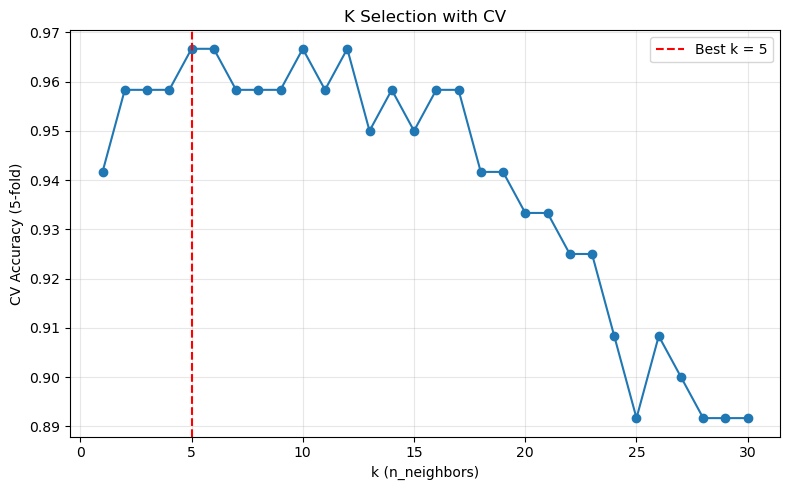

In [26]:
# Plot k vs CV accuracy
plt.figure(figsize=(8,5))
plt.plot(k_values, cv_scores, marker='o')
plt.axvline(best_k, color='red', linestyle='--', label=f'Best k = {best_k}')
plt.xlabel("k (n_neighbors)")
plt.ylabel("CV Accuracy (5-fold)")
plt.title("K Selection with CV")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "k_vs_cv_accuracy.png"))
plt.show()


In [27]:
# ----------------------------
# Train final KNN with best_k
# ----------------------------
knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(X_train_scaled, y_train)
y_pred = knn_final.predict(X_test_scaled)

In [28]:
print("\nFinal Model Evaluation:")
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=class_names))


Final Model Evaluation:
Test Accuracy: 0.9333333333333333

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.83      1.00      0.91        10
           2       1.00      0.80      0.89        10

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30



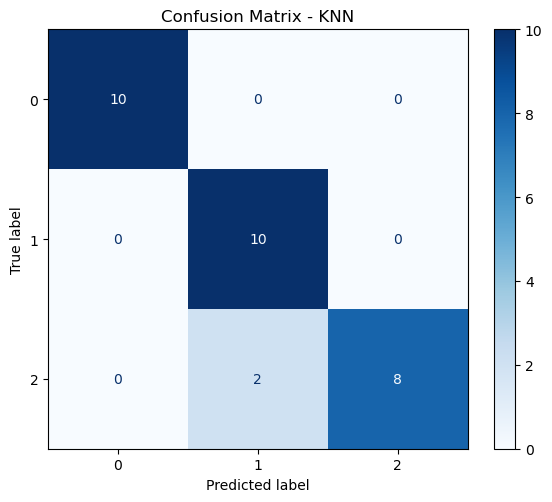

In [29]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6,5))
disp.plot(ax=ax, cmap="Blues", values_format='d')
plt.title("Confusion Matrix - KNN")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "confusion_matrix.png"))
plt.show()

In [30]:
# ----------------------------
# Decision boundary (2D) - use PCA if >2 features
# ----------------------------
def plot_decision_boundary_2d(model, X_train_s, y_train_arr, X_test_s, y_test_arr, title="Decision Boundary (2D)"):
    # create a mesh and plot decision regions
    x_min, x_max = X_train_s[:, 0].min() - 1, X_train_s[:, 0].max() + 1
    y_min, y_max = X_train_s[:, 1].min() - 1, X_train_s[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8,6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap="Pastel1")
    sns.scatterplot(x=X_train_s[:, 0], y=X_train_s[:, 1], hue=y_train_arr, palette="deep", edgecolor='k', s=50, legend='brief')
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "decision_boundary.png"))
    plt.show()


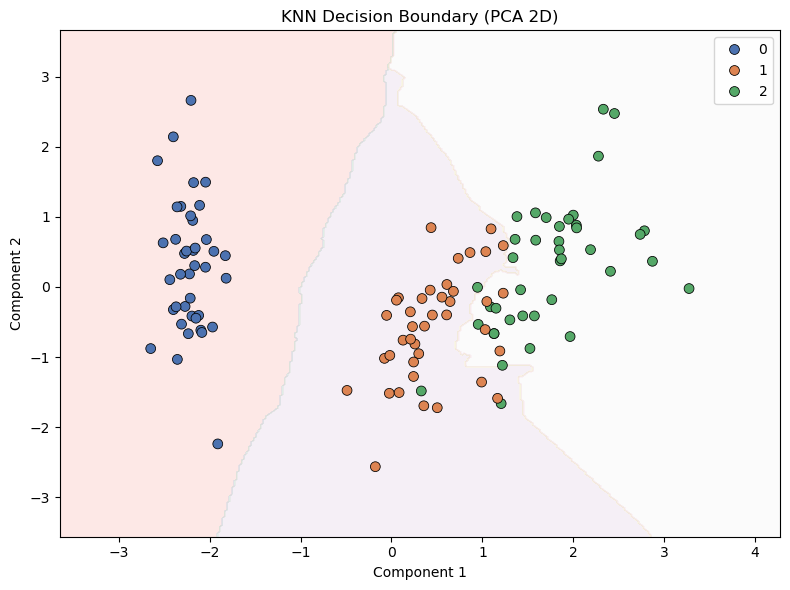

In [31]:
if X_train_scaled.shape[1] == 2:
    plot_decision_boundary_2d(knn_final, X_train_scaled, y_train, X_test_scaled, y_test, title="KNN Decision Boundary (2 features)")
else:
    # Use PCA to reduce to 2D for visualization (fit PCA on scaled train features)
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # Train a KNN on PCA components (for visualization only)
    knn_vis = KNeighborsClassifier(n_neighbors=best_k)
    knn_vis.fit(X_train_pca, y_train)
    plot_decision_boundary_2d(knn_vis, X_train_pca, y_train, X_test_pca, y_test, title="KNN Decision Boundary (PCA 2D)")


In [32]:
# ----------------------------
# Save model / scaler optionally (code commented out)
# ----------------------------
# import joblib
# joblib.dump(knn_final, os.path.join(OUTPUT_DIR, "knn_final.joblib"))
# joblib.dump(scaler, os.path.join(OUTPUT_DIR, "scaler.joblib"))

print(f"\nAll plots saved to folder: {OUTPUT_DIR}")


All plots saved to folder: task6_outputs
